In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# scipy has a good stats library
import scipy.stats as stats

# Statmodels does some heavy-duty stats
import statsmodels.api as sm

# scikit-learn is focused on machine learning,
# which _includes_ regression models
from sklearn import linear_model


In [2]:
# HadCRUT4 data
ds = xr.open_dataset("/Users/brianpm/Dropbox/Data/HadCRUT/HadCRUT.4.6.0.0.median.nc")
temperature = ds['temperature_anomaly']


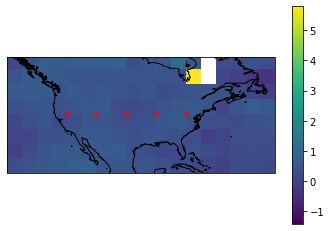

In [3]:
# Take a look at the 1990s over North America
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
dmy = temperature.sel(time=slice('1990-01-01', '1999-12-31')).mean(dim='time')
mlon, mlat = np.meshgrid(ds['longitude'], ds['latitude'])
img = ax.pcolormesh(mlon, mlat, dmy, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-140, -50, 20, 50])
ax.plot(-120, 40, marker='x', color='red')
ax.plot(-110, 40, marker='x', color='red')
ax.plot(-100, 40, marker='x', color='red')
ax.plot(-90, 40, marker='x', color='red')
ax.plot(-80, 40, marker='x', color='red')
fig.colorbar(img)


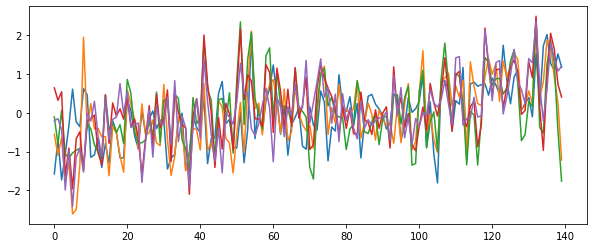

In [4]:
# Take a look at the time series at those 5 points
t1 = temperature.sel(latitude=40, longitude=-120, method='nearest').sel(time=slice('1880-01-01',None))
t2 = temperature.sel(latitude=40, longitude=-110, method='nearest').sel(time=slice('1880-01-01',None))
t3 = temperature.sel(latitude=40, longitude=-100, method='nearest').sel(time=slice('1880-01-01',None))
t4 = temperature.sel(latitude=40, longitude=-90, method='nearest').sel(time=slice('1880-01-01',None))
t5 = temperature.sel(latitude=40, longitude=-80, method='nearest').sel(time=slice('1880-01-01',None))
# apply annual mean to make things look more clear
t1 = t1.groupby("time.year").mean(dim='time')
t2 = t2.groupby("time.year").mean(dim='time')
t3 = t3.groupby("time.year").mean(dim='time')
t4 = t4.groupby("time.year").mean(dim='time')
t5 = t5.groupby("time.year").mean(dim='time')
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t1)
ax.plot(t2)
ax.plot(t3)
ax.plot(t4)
ax.plot(t5)

0.05874492796119116 0.06850592632654097
 $\hat{y}$ = 0.05874492796119116 + 0.4466246002578045 × x
$\hat{y}$ = 0.05874492796119116 + 0.4466246002578045 × x; r-value: 0.40923448565597825, p = 5.15786763792047e-07
$\hat{y}$ = 0.06826289547230308 + 0.6382109948217655 × x; r-value: 0.6581709111961016, p = 9.911714075773493e-19
$\hat{y}$ = -0.055401078913861576 + 0.8463060424505772 × x; r-value: 0.8055119637667945, p = 3.651856151820549e-33
$\hat{y}$ = -0.0031926865178536837 + 0.6285875944103367 × x; r-value: 0.5795421193958588, p = 6.276253022529262e-14


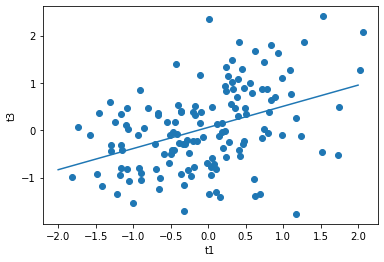

In [5]:
# Let's try to predict t3 using the others

# 1st -- do the regression for each one separately
result = stats.linregress(t1.values, t3.values)
print(result.intercept, result.intercept_stderr)
# Nuts! Missing values ruin everything.
# I took a look, and all the missing values are in the early years, so I changed to just take 1880 onward.

# This result can be turned into the linear model:
print(f" $\hat{{y}}$ = {result.intercept} + {result.slope} \u00D7 x")

# and we can quickly visualize it:
fig, ax = plt.subplots()
ax.scatter(t1, t3)
synthetic_xvalues = np.arange(-2, 3)
ax.plot(synthetic_xvalues, result.intercept + result.slope * synthetic_xvalues)
ax.set_xlabel("t1")
ax.set_ylabel("t3")

# repeat for the others:
for predictor in [t1, t2, t4, t5]:
    result = stats.linregress(predictor.values, t3.values)
    print(f"$\hat{{y}}$ = {result.intercept} + {result.slope} \u00D7 x; r-value: {result.rvalue}, p = {result.pvalue}")



In [6]:
# the scikit-learn way
# FIRST we will reproduce the simple linear regression from above, then move to multiple linear regression.

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(t1.values.reshape(-1,1), t3.values.reshape(-1,1))

#
# Find out the coefficients
#
print(regr.coef_)  # Same as slope before
print(regr.score(t1.values.reshape(-1,1), t3.values.reshape(-1,1)))  # This is the r**2 value
#
# One point here: Even though it seems fancy to use scikit-learn, it's actually not as
# convenient as just using scipy's linregress for most simple applications.

[[0.44662467]]
0.1674728489120063


In [7]:
#
#  Multiple Linear Regression
#

# The idea here is to get a model:
# yhat = const + beta1 * x1 + beta2 * x2 ... for however many predictors, x_i, you have. 

#
# Method 1: Use numpy's linear algebra
#
predictors = np.stack([t1.values, t2.values, t4.values, t5.values], axis=1)
print(predictors.shape)
predictors = np.c_[predictors, np.ones(predictors.shape[0])]  # add bias term
# result = stats.linregress(t1.values, predictors)
np_rcoefs = np.linalg.lstsq(predictors, t3.values, rcond=None)[0]
print(f"Numpy method coefficients: {np_rcoefs}")


#
# Method 2: Use scikit-learn
#
predictors = np.stack([t1.values, t2.values, t4.values, t5.values], axis=1)
regr = linear_model.LinearRegression()
regr.fit(predictors, t3.values)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# --> Same coefficients, check.


#
# Method 3: Use statsmodels
#
# with statsmodels
predictors = sm.add_constant(predictors) # adding a constant, just like the `np.c_` step in Method 1.
 
model = sm.OLS(t3.values, predictors).fit()
predictions = model.predict(predictors) 
 
print_model = model.summary()
print(print_model)
#
# Statsmodels gives a ton more output here. Surprisingly, the "condition number" is not very large.
# A large condition number is an indicator that the solution is collapsing due to the colinearity 
# of the predictors. 
#

# Point here: We know, or can show, that the predictors are not independent,
#             and we can use a method that can deal with that circumstance.

#
# Method 4: scikit-learn again, but using Ridge Regression
#

ridgeregr = linear_model.Ridge()

predictors = np.stack([t1.values, t2.values, t4.values, t5.values], axis=1)

ridgeregr.fit(predictors, t3.values)

print('Intercept: \n', ridgeregr.intercept_)
print('Coefficients: \n', ridgeregr.coef_)

# --> The coefficients are _similar_, but not identical. This is because ridge regression
# uses a diffent cost function (it's not just least squares).

(140, 4)
Numpy method coefficients: [-0.00584373  0.3256313   1.21685249 -0.63428927 -0.03967961]
Intercept: 
 -0.03967961
Coefficients: 
 [-0.00584347  0.3256309   1.2168524  -0.634289  ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     146.6
Date:                Sat, 23 Oct 2021   Prob (F-statistic):           4.16e-48
Time:                        14:15:40   Log-Likelihood:                -63.491
No. Observations:                 140   AIC:                             137.0
Df Residuals:                     135   BIC:                             151.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef

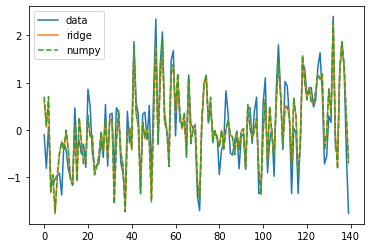

In [8]:
# we might want to verify the "goodness of fit" of the model,
# so let's start by just eyeballing it:
# plot the original data, the ridge regression and one of the others.

yhat = ridgeregr.predict(predictors)

fig, ax = plt.subplots()
ax.plot(t3, label='data')
ax.plot(yhat, label='ridge')

np_fit = np_rcoefs[0]*t1.values + \
         np_rcoefs[1]*t2.values + \
         np_rcoefs[2]*t4.values + \
         np_rcoefs[3]*t5.values + \
         np_rcoefs[4]
ax.plot(np_fit, linestyle='dashed', label='numpy')
ax.legend()
# The model is actualy pretty much identical even though the coefficents are different. 

In [9]:
# When all the predictor variables are standardized, I think 
# the coefficients can be directly compared as a measure of power.
# BUT some methods depend on the order that the predictors are in.

# let's do a couple permutations to see if it changes
predictors = np.stack([t1.values, t2.values, t4.values, t5.values], axis=1)
ridgeregr.fit(predictors, t3.values)
print('Intercept: \n', ridgeregr.intercept_)
print('Coefficients: \n', ridgeregr.coef_)

predictors = np.stack([t5.values, t4.values, t2.values, t1.values], axis=1)
ridgeregr.fit(predictors, t3.values)
print('Intercept: \n', ridgeregr.intercept_)
print('Coefficients: \n', ridgeregr.coef_)

predictors = np.stack([t4.values, t1.values, t5.values, t2.values], axis=1)
ridgeregr.fit(predictors, t3.values)
print('Intercept: \n', ridgeregr.intercept_)
print('Coefficients: \n', ridgeregr.coef_)

# --> Ridge regression coefficients are not very sensitive to order,
#     but it does have small quantitative effects.

#
# This would indicate that t4 is the most important predictor.
# This conclusion is supported by our individual regressions, where the correlation between t3 & t4 was 0.8.
#

Intercept: 
 -0.03562504
Coefficients: 
 [-0.00530037  0.3299197   1.1372246  -0.5576908 ]
Intercept: 
 -0.035625055
Coefficients: 
 [-0.5576911   1.1372249   0.32991973 -0.00530041]
Intercept: 
 -0.035625055
Coefficients: 
 [ 1.1372249  -0.00530029 -0.5576912   0.32991955]


Cross validation optimal alpha = 0.05722367659350217


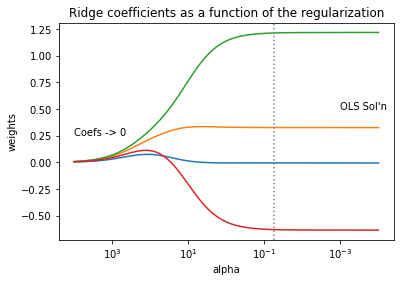

In [10]:
# One more thing. There's a parameter in ridge (the complexity factor, or regularization)
# see: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

# our example probably won't show much interesting behavior, but let's see:
n_alphas = 200
alphas = np.logspace(-4, 4, n_alphas)

predictors = np.stack([t1.values, t2.values, t4.values, t5.values], axis=1)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(predictors, t3.values)
    coefs.append(ridge.coef_)



# According to
# https://jbhender.github.io/Stats506/F17/Projects/G13/Python.html
# we can also try to get the optimal value for alpha:
###Fit Ridge regression through cross validation
regr_cv=linear_model.RidgeCV(alphas=np.logspace(-3, 3, 100))
model_cv=regr_cv.fit(predictors,t3.values)
print(f"Cross validation optimal alpha = {model_cv.alpha_}")

# #############################################################################
# Display results

fig, ax = plt.subplots()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Ridge coefficients as a function of the regularization')

ax.text(1e-3, 0.5, "OLS Sol'n")
ax.text(10000, 0.25, "Coefs -> 0")
ax.axvline(model_cv.alpha_, linestyle='dotted', color='gray')

# Based on this, the least squares solution regime (small alpha)
# is near the regularization parameter's cross-validation optimum
# so maybe it makes sense that ridge and OLS produced similar results.
# The DEFAULT alpha values is 1, so let's double check the coefficients with the "best" alpha

In [11]:
final_ridge = linear_model.Ridge(alpha=model_cv.alpha_, fit_intercept=True)
final_ridge.fit(predictors, t3.values)
print('Intercept: \n', final_ridge.intercept_)
print('Coefficients: \n', final_ridge.coef_)
# These coefficients are significantly different, but qualitatively produce the same result:
# t4 is best predictor of t3.

Intercept: 
 -0.039427258
Coefficients: 
 [-0.00583669  0.32592982  1.2118943  -0.629514  ]


In [17]:
import seaborn as sns
import pandas as pd

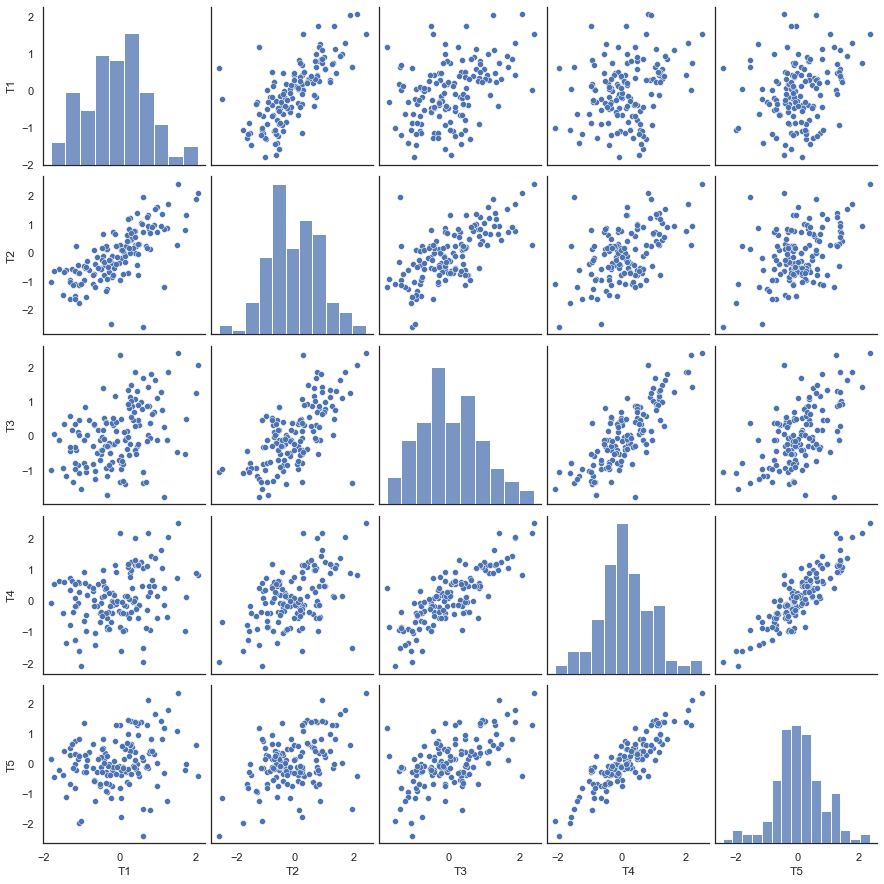

In [18]:
sns.set_theme(style="white")
stackeddata = np.stack([t1.values, t2.values, t3.values, t4.values, t5.values], axis=1)
df = pd.DataFrame(stackeddata, columns = ['T1','T2','T3','T4','T5'])
sns.pairplot(df)
